In [20]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [24]:
import os

In [81]:
def mk_dir(p):
    if not os.path.exists(p):
        os.mkdir(p)

mk_dir('./qc_fastq')
mk_dir('./deseq')
mk_dir('./plots')

In [50]:
%%R
list.files('fastq')

[1] "Input_T1_S43_L006_R1_001.fastq.gz" "Input_T2_S44_L006_R1_001.fastq.gz"
[3] "Input_U1_S41_L006_R1_001.fastq.gz" "Input_U2_S42_L006_R1_001.fastq.gz"
[5] "IP_T1_S47_L006_R1_001.fastq.gz"    "IP_T2_S48_L006_R1_001.fastq.gz"   
[7] "IP_U1_S45_L006_R1_001.fastq.gz"    "IP_U2_S46_L006_R1_001.fastq.gz"   


I've started from bam files previously mapped by Hani or Alex. All `bam`  files renamed in this format: 
> `<treatment>.<input/m6A>.bam`

In [14]:
%%bash
cd bam/
for f in Input_*; do 
    o=${f/Input_/};o=${o/_S4[1-4].bam/.input.bam}; mv $f $o; 
done
for f in IP_*; do 
    o=${f/IP_/};o=${o/_S4[5-8].bam/.m6A.bam}; mv $f $o; 
done
cd ../

In [15]:
%%R
list.files('bam')

[1] "T1.input.bam" "T1.m6A.bam"   "T2.input.bam" "T2.m6A.bam"   "U1.input.bam"
[6] "U1.m6A.bam"   "U2.input.bam" "U2.m6A.bam"  


# Peakcalling 

## Control

In [ ]:
%%R 
library(exomePeak)
txdb <- makeTxDbFromGFF('/rumi/shams/genomes/hg38/gencode.v28.annotation.gtf',organism='Homo sapiens')
setwd("bam/")
print (txdb)
res <- exomepeak(
    TXDB=txdb,
    IP_BAM=c("U1.m6A.bam","U2.m6A.bam"),
    INPUT_BAM=c("U1.input.bam","U2.input.bam"),
    OUTPUT_DIR='../exomepeak',
    EXPERIMENT_NAME='ctrl'
)
saveRDS(res, paste('../exomepeak/ctrl.rds', sep='/'))
setwd("../")

R[write to console]: Import genomic features from the file as a GRanges object ... 
R[write to console]: OK

R[write to console]: Prepare the 'metadata' data frame ... 
R[write to console]: OK

R[write to console]: Make the TxDb object ... 
R[write to console]: OK



TxDb object:
# Db type: TxDb
# Supporting package: GenomicFeatures
# Data source: /rumi/shams/genomes/hg38/gencode.v28.annotation.gtf
# Organism: Homo sapiens
# Taxonomy ID: 9606
# miRBase build ID: NA
# Genome: NA
# transcript_nrow: 203835
# exon_nrow: 693612
# cds_nrow: 273085
# Db created by: GenomicFeatures package from Bioconductor
# Creation time: 2020-04-08 01:53:01 +0000 (Wed, 08 Apr 2020)
# GenomicFeatures version at creation time: 1.32.3
# RSQLite version at creation time: 2.1.5
# DBSCHEMAVERSION: 1.2


R[write to console]: 'select()' returned 1:many mapping between keys and columns



[1] "Divide transcriptome into chr-gene-batch sections ..."
[1] "Get Reads Count ..."
[1] "This step may take a few hours ..."
[1] "0.286 %"
[1] "0.571 %"
[1] "0.857 %"
[1] "1.14 %"
[1] "1.43 %"
[1] "1.71 %"
[1] "2 %"
[1] "2.29 %"
[1] "2.57 %"
[1] "2.86 %"
[1] "3.14 %"
[1] "3.43 %"
[1] "3.71 %"
[1] "4 %"
[1] "4.29 %"
[1] "4.57 %"
[1] "4.86 %"
[1] "5.14 %"
[1] "5.43 %"
[1] "5.71 %"
[1] "6 %"
[1] "6.29 %"
[1] "6.57 %"
[1] "6.86 %"
[1] "7.14 %"
[1] "7.43 %"
[1] "7.71 %"
[1] "8 %"
[1] "8.29 %"
[1] "8.57 %"
[1] "8.86 %"
[1] "9.14 %"
[1] "9.43 %"
[1] "9.71 %"
[1] "10 %"
[1] "10.3 %"
[1] "10.6 %"
[1] "10.9 %"
[1] "11.1 %"
[1] "11.4 %"
[1] "11.7 %"
[1] "12 %"
[1] "12.3 %"
[1] "12.6 %"
[1] "12.9 %"
[1] "13.1 %"
[1] "13.4 %"
[1] "13.7 %"
[1] "14 %"
[1] "14.3 %"
[1] "14.6 %"
[1] "14.9 %"
[1] "15.1 %"
[1] "15.4 %"
[1] "15.7 %"
[1] "16 %"
[1] "16.3 %"
[1] "16.6 %"
[1] "16.9 %"
[1] "17.1 %"
[1] "17.4 %"
[1] "17.7 %"
[1] "18 %"
[1] "18.3 %"
[1] "18.6 %"
[1] "18.9 %"
[1] "19.1 %"
[1] "19.4 %"
[1] "19.

In [7]:
!head -n 20 exomepeak/ctrl/peak.bed

# chr	chromStart	chromEnd	name	score	strand	thickStart	thickEnd	itemRgb	blockCount	blockSizes	blockStarts
chr1	853842	854022	ENSG00000228794.8	7.4e-09	+	853842	854022	0	1	180,	0
chr1	1055278	1055369	ENSG00000188157.14	0.00032	+	1055278	1055369	0	1	91,	0
chr1	1055518	1055669	ENSG00000188157.14	8.9e-06	+	1055518	1055669	0	1	151,	0
chr1	1232951	1233310	ENSG00000176022.4	3.2e-33	+	1232951	1233310	0	1	359,	0
chr1	1233458	1234235	ENSG00000176022.4	9.99999999999999e-288	+	1233458	1234235	0	1	777,	0
chr1	1234622	1235011	ENSG00000176022.4	0	+	1234622	1235011	0	1	389,	0
chr1	1327767	1328065	ENSG00000224051.6	5e-11	+	1327767	1328065	0	1	298,	0
chr1	1328361	1328511	ENSG00000224051.6	4.8e-08	+	1328361	1328511	0	1	150,	0
chr1	1328569	1328838	ENSG00000224051.6	1.6e-17	+	1328569	1328838	0	1	269,	0
chr1	1400709	1401571	ENSG00000224870.6	0	+	1400709	1401571	0	1	862,	0
chr1	1672764	1672944	ENSG00000269737.2	7.8e-08	+	1672764	1672944	0	1	180,	0
chr1	2228844	2228935	ENSG00000157933.9	1.3e-05	+	2228844	2228

### Plot _Guitar_ 
Now, let's draw metagene plots for control samples:
(using seprate env: `Guitar`)

In [2]:
%reload_ext rpy2.ipython

/rumi/shams/abe/anaconda3/envs/guitar/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [4]:
%%R
library(Guitar)

In [5]:
%%R
txdb <- makeTxDbFromGFF('/rumi/shams/genomes/hg38/gencode.v28.annotation.gtf',organism='Homo sapiens')

R[write to console]: Import genomic features from the file as a GRanges object ... 
R[write to console]: OK

R[write to console]: Prepare the 'metadata' data frame ... 
R[write to console]: OK

R[write to console]: Make the TxDb object ... 
R[write to console]: OK



In [6]:
%%R
GuitarPlot(txTxdb=txdb,stBedFiles="exomepeak/ctrl/peak.bed",miscOutFilePrefix='plot')

[1] "20200409182002"
[1] "There are 203835 transcripts of 58381 genes in the genome."
[1] "total 203835 transcripts extracted ..."
[1] "total 94682 transcripts left after ambiguity filter ..."
[1] "total 94682 transcripts left after check chromosome validity ..."
[1] "total 11625 mRNAs left after component length filter ..."
[1] "total 56222 ncRNAs left after ncRNA length filter ..."
[1] "generate components for all tx"
[1] "generate components for mRNA"
[1] "generate components for lncRNA"
[1] "generate chiped transcriptome"
[1] "generate coverage checking ranges for tx"
[1] "generate coverage checking ranges for mrna"
[1] "generate coverage checking ranges for ncrna"
[1] "20200409182409"
[1] "import BED file exomepeak/ctrl/peak.bed"
[1] "sample 10 points for Group1"
[1] "start figure plotting for tx ..."
[1] "start figure plotting for mrna ..."
[1] "start figure plotting for ncrna ..."


In [7]:
!magick -density 300 plot_mrna_test.pdf -flatten -quality 90 plot_mrna_test.png
!magick -density 300 plot_ncrna_test.pdf -flatten -quality 90 plot_ncrna_test.png
!magick -density 300 plot_tx_test.pdf -flatten -quality 90 plot_tx_test.png

In [225]:
mv -v *p[nd][gf] plots/

renamed 'plot_mrna_test.pdf' -> 'plots/plot_mrna_test.pdf'
renamed 'plot_mrna_test.png' -> 'plots/plot_mrna_test.png'
renamed 'plot_ncrna_test.pdf' -> 'plots/plot_ncrna_test.pdf'
renamed 'plot_ncrna_test.png' -> 'plots/plot_ncrna_test.png'
renamed 'plot_tx_test.pdf' -> 'plots/plot_tx_test.pdf'
renamed 'plot_tx_test.png' -> 'plots/plot_tx_test.png'


<table>
  <tr>
    <td><img src="plots/plot_mrna_test.png" style="width:600px">
  <tr>
<table>
<table>
  <tr>
    <td><img src="plots/plot_ncrna_test.png" style="width:300px">
    <td><img src="plots/plot_tx_test.png" style="width:300px">
  <tr>
<table>

### Motif analysis 

using `cgat` env to use [CGAT - Computational Genomics Analysis Tools](https://www.cgat.org/downloads/public/cgat/documentation/) and use 

In [26]:
%%bash 
cd ~/People/Gilbertlab/Decitabine_treatment/MeRIP-seq_treated/exomepeak/ctrl/
# sort | merge by name 
cat peak.bed | sort -k1,1 -k2,2n peak.bed | cgat bed2bed --method=merge --merge-by-name |  awk '! /#/' > peak.edit.bed
# get fasta for the cordinate sequnces (-split removes introns)
bedtools getfasta -name -s -fi /rumi/shams/genomes/hg38/hg38.fa -bed peak.edit.bed -split -fo peak.fa
# prepare fasta file for FIRE
perl /flash/hani/bin/Tools/prep_seqs_for_teiser_run.pl peak.fa peaks

In [36]:
%%bash 
cd ~/People/Gilbertlab/Decitabine_treatment/MeRIP-seq_treated/exomepeak/ctrl/
# run FIRE --doskipdiscovery=0
perl $FIREDIR/fire.pl --expfile=peaks_teiser.txt --exptype=discrete --fastafile_rna=peaks_teiser.fa --nodups=1 --dodna=0 --dodnarna=0 --species=human --oribiasonly=0
mv peaks_teiser.txt_FIRE/ skipdiscovery.0_FIRE

To run `FIRE` non-discovery mode we need to list in a file like `motifs_of_interest.txt` 

In [35]:
%%bash 
cd ~/People/Gilbertlab/Decitabine_treatment/MeRIP-seq_treated/exomepeak/T_vs_U/
# run FIRE --doskipdiscovery=1
perl $FIREDIR/fire.pl --expfile=peaks_teiser.txt --exptype=discrete --fastafile_rna=peaks_teiser.fa --nodups=1 --dodna=0 --dodnarna=0 --species=human --doskipdiscovery=1 --motiffile_rna=motifs_of_interest.txt --oribiasonly=0
rm -r skipdiscovery.1_FIRE
mv -v peaks_teiser.txt_FIRE/ skipdiscovery.1_FIRE

Tue Apr  7 22:16:09 UTC 2020
RNA, Processing peaks_teiser.txt_FIRE/RNA/peaks_teiser.txt
RNA, Step 2: skip seed optimization, use -motiffile_rna option instead.
RNA, Step 3: evaluation of motif significances.
Processing motif [AG]GAC.
MI=0.00287461
Shuffle rank=0
Z-score=57.222
Sigificance category= OK-NO-SEED
Robustness (jn_f=3)=10/10

Processing motif [AGT][AG]AC[ACT].
MI=0.00103316
Shuffle rank=0
Z-score=19.393
Sigificance category= OK-NO-SEED
Robustness (jn_f=3)=9/10

RNA, Step 3.5: creating binary expression profiles.
RNA, Step 4: discovery of distance constraints.
Read 2 motifs.
Read 20328 (genes) x 2 (conditions) matrix.
Read 20328 (genes) x 1 (conditions) matrix.
Reading sequences and building motif profiles ...Done.
Average sequence length is 426.
Quantized E vector into 2 bins
Motif [AG]GAC, present in 17970 genes.
       Average distance: MI=0.0037, rank=0/10000, Z=64.9084, mbins=2
  Orientation bias {5'): MI=0.0029, rank=0/10000, Z=57.2122
  Orientation bias (3'): MI=0.0000,

corrupted size vs. prev_size
Aborted (core dumped)
corrupted size vs. prev_size
Aborted (core dumped)
corrupted size vs. prev_size
Aborted (core dumped)
Segmentation fault (core dumped)
Can't use 'defined(@array)' (Maybe you should just omit the defined()?) at /flash/hani/bin/FIRE-1.1/SCRIPTS/draw_position_histogram.pl line 134.
Can't locate Hypergeom.pm in @INC (you may need to install the Hypergeom module) (@INC contains: /nvme/bins/FIRE-1.1/SCRIPTS/../modules/lib/perl5/site_perl/5.12.4/darwin-thread-multi-2level/nvme/bins/FIRE-1.1/SCRIPTS/../modules/lib/perl5/site_perl/5.10.0/darwin-thread-multi-2level/Hypergeom.pm /nvme/bins/FIRE-1.1/SCRIPTS/../modules/lib/perl5/site_perl/5.18.2/darwin-thread-multi-2level/Hypergeom.pm /nvme/bins/FIRE-1.1/SCRIPTS/../modules/lib/perl5/site_perl/5.22.0/x86_64-linux/Hypergeom.pm /flash/hani/bin/FIRE-1.1/SCRIPTS /rumi/shams/abe/perl5/lib/perl5/5.26.2/x86_64-linux-thread-multi /rumi/shams/abe/perl5/lib/perl5/5.26.2 /rumi/shams/abe/perl5/lib/perl5/x86_64-

In [38]:
!cd /rumi/shams/abe/People/Gilbertlab/Decitabine_treatment/MeRIP-seq_treated

!magick -density 300 exomepeak/T_vs_U/skipdiscovery.0_FIRE/RNA/peaks_teiser.txt.summary.pdf -flatten -quality 90 exomepeak/T_vs_U/skipdiscovery.0_FIRE/RNA/peaks_teiser.txt.summary.png
!magick -density 300 exomepeak/T_vs_U/skipdiscovery.1_FIRE/RNA/peaks_teiser.txt.summary.pdf -flatten -quality 90 exomepeak/T_vs_U/skipdiscovery.1_FIRE/RNA/peaks_teiser.txt.summary.png

/rumi/shams/abe/People/Gilbertlab/Decitabine_treatment/MeRIP-seq_treated


<img src="exomepeak/T_vs_U/skipdiscovery.1_FIRE/RNA/peaks_teiser.txt.summary.png" style="width:900px">

# Differential peaks 

### Running a custom pipeline
Here we're using https://github.com/gold-lab/bed12ToGTF to make gtf file from control exomepeak result.

https://metacpan.org/pod/Bio::FeatureIO::gtf

In [11]:
%%bash
cat exomepeak/ctrl/peak.bed | sort -k4 | \
# rename features peak by peak
awk -F "\t" '{OFS=FS}NR>1{$4=$4"_peak"}; cnt[$4]++{$4=$4"_"cnt[$4]} 1' | \
# bed12 to gtf
perl ~/Workflows/bed12ToGTF/bed12ToGTF.1.pl | \
awk '{gsub(/\"|\;/,"")}1''{gsub(/transcript_id/,"gene_id")}1''{gsub(/ exon_number [[:digit:]]/,"")}1' > exomepeak/ctrl/peak.gtf


In [13]:
cat exomepeak/ctrl/peak.gtf | head

# chr	blank	transcript	1	chromEnd	.	strand	.	gene_id name
chr1	blank	transcript	169853401	169853641	.	-	.	gene_id ENSG00000000457.13_peak
chr1	blank	exon	169853401	169853641	.	-	.	gene_id ENSG00000000457.13_peak
chr1	blank	transcript	169853390	169853630	.	+	.	gene_id ENSG00000000460.16_peak
chr1	blank	exon	169853390	169853630	.	+	.	gene_id ENSG00000000460.16_peak
chr6	blank	transcript	53498597	53498777	.	-	.	gene_id ENSG00000001084.11_peak
chr6	blank	exon	53498597	53498777	.	-	.	gene_id ENSG00000001084.11_peak
chr6	blank	transcript	41097505	41098607	.	+	.	gene_id ENSG00000001167.14_peak
chr6	blank	exon	41097505	41098607	.	+	.	gene_id ENSG00000001167.14_peak
chr6	blank	transcript	41098756	41099143	.	+	.	gene_id ENSG00000001167.14_peak_2
cat: write error: Broken pipe


In [27]:
mk_dir('./peakcount')

In [28]:
%%bash
# %%bash --err error
for f in bam/T*.bam; do 
    out=${f/.bam/.fc}; 
    out=${out/bam/peakcount}; 
    echo featureCounts -T 12 -O -t exon -g gene_id -a exomepeak/ctrl/peak.gtf -o $out $f;
    featureCounts -T 12 -O -t exon -g gene_id -a exomepeak/ctrl/peak.gtf -o $out $f;
done

featureCounts -T 12 -O -t exon -g gene_id -a exomepeak/ctrl/peak.gtf -o peakcount/T1.input.fc bam/T1.input.bam
featureCounts -T 12 -O -t exon -g gene_id -a exomepeak/ctrl/peak.gtf -o peakcount/T1.m6A.fc bam/T1.m6A.bam
featureCounts -T 12 -O -t exon -g gene_id -a exomepeak/ctrl/peak.gtf -o peakcount/T2.input.fc bam/T2.input.bam
featureCounts -T 12 -O -t exon -g gene_id -a exomepeak/ctrl/peak.gtf -o peakcount/T2.m6A.fc bam/T2.m6A.bam



        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v1.6.0

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 1 BAM file                                       ||
||                           S bam/T1.input.bam                               ||
||                                                                            ||
||             Output file : peakcount/T1.input.fc                            ||
||                 Summary : peakcount/T1.input.fc.summary       

### Id transfer
Read gene names from gtf file

In [20]:
import pandas as pd 
import os

def gtf_id_transfer(gtf):
    # awk code to extract gene ID and Name 
    gtf_raw = os.popen("cat " + gtf + " | awk 'BEGIN{FS=\"\t\"}{split($9,a,\";\"); if($3~\"gene\") print a[1]\"\t\"a[3]}' | sed 's/gene_id \"//' | sed 's/gene_name \"//' | sed 's/\"//g' | sed 's/ //g'").read().split('\n')
    # data frame 
    gtf_df = pd.DataFrame(
        # col: Names 
        data=[i.split('\t')[1] for i in gtf_raw[:len(gtf_raw)-1]],
        # index: ids 
        index=[i.split('\t')[0] for i in gtf_raw[:len(gtf_raw)-1]],
        columns=['Name'], dtype=str)
    return gtf_df

gtf = '/rumi/shams/genomes/hg38/gencode.v28.annotation.gtf'
gtf_df = gtf_id_transfer(gtf)

load R

In [14]:
%reload_ext rpy2.ipython

### Differential methylation

In [22]:
%%R
library(DESeq2)
library(tidyverse)
library(ggplot2)
require(ggrepel)
library(patchwork)

pca = list(); vol = list(); hist = list()

using `DESeq2` to find differential methylation peaks:

In [210]:
%%R -i gtf_df

files.input <- list.files(path = 'peakcount',pattern=".input.fc$")
files.m6A <- list.files(path = 'peakcount',pattern=".m6A.fc$")
files = c(files.input,files.m6A)

datalist <- lapply(files, function(x){read.table(file=paste('peakcount/', x, sep = ""),skip=1,sep='\t',header=TRUE,colClasses=c(NA, "NULL", "NULL", "NULL", "NULL", "NULL", NA),check.names=F)})
m <- Reduce(function(...) merge(..., by=1, all = TRUE), datalist)
rownames(m) <- m[,1]
m <- m[,-1]
m[is.na(m)]<-0
m <- round(m)
colnames(m) <- substr(colnames(m), 5 , nchar(colnames(m)) - 4)

# Design: m6A vs input 
ip = c(rep('input',2),rep('m6A',2))
colData <- data.frame(cond = ip, row.names=colnames(m))
# diff_peak 
dds <- DESeqDataSetFromMatrix(countData = m, colData = colData, design = ~ cond)
dds$cond <- relevel(dds$cond, ref="input")
dds <- DESeq(dds)
    
# normalized counts 
ncu <- counts(dds, normalized=TRUE)
res <- results(dds)
res <- as.data.frame(res)
# idtransfer
peak_ids = strsplit(rownames(m), '_',)
ids = unlist(lapply(peak_ids, '[[', 1))
res$name = gtf_df[ids,]
# save files 
write.table(res, 'deseq/peak_m6A_vs_input.txt', sep="\t", quote=FALSE, col.names=NA)
write.table(ncu, file='deseq/peak_count_table_DE2norm.txt',sep="\t", quote=FALSE, col.names=colnames(m)) 
write.table(m, file='deseq/peak_count_table_raw.txt',sep="\t", quote=FALSE, col.names=colnames(m))

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



## Plots

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



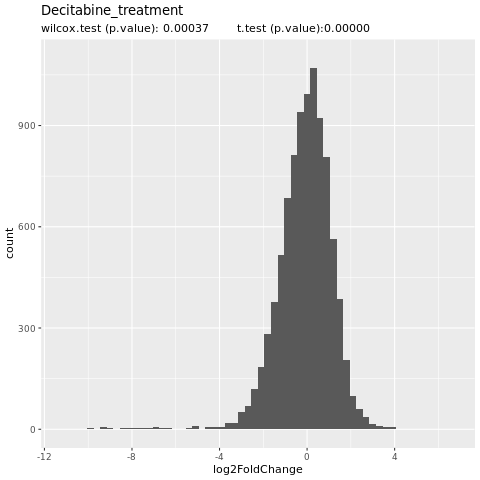

In [211]:
%%R 
d <- res$log2FoldChange[!is.na(res$log2FoldChange)]
w <- wilcox.test(res$log2FoldChange,mu = 0, alternative = "less")

t <- t.test(res$log2FoldChange, mu=0)

h = ggplot(res, aes(x=log2FoldChange)) +
        ggtitle(
            'Decitabine_treatment',
            sprintf("wilcox.test (p.value): %.5f \t t.test (p.value):%.5f", w$p.value, t$p.value)
        ) +
        ylim(c(0,1100)) +
        geom_histogram(binwidth=0.3)

ggsave("plots/peak_Histograms.png", plot = h, device = 'png', dpi = 300)
ggsave("plots/peak_Histograms.pdf", plot = h, device = 'pdf', dpi = 300)
h

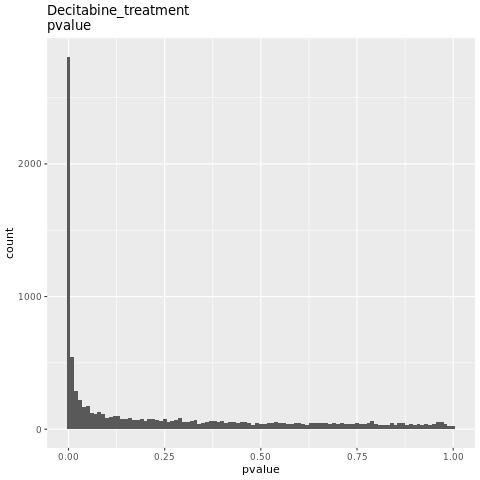

In [223]:
%%R 
ggplot(res, aes(x=pvalue)) +
        ggtitle('Decitabine_treatment\npvalue') +
#         ylim(c(0,1100)) +
        geom_histogram(binwidth=0.01)


#### volcanos 

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



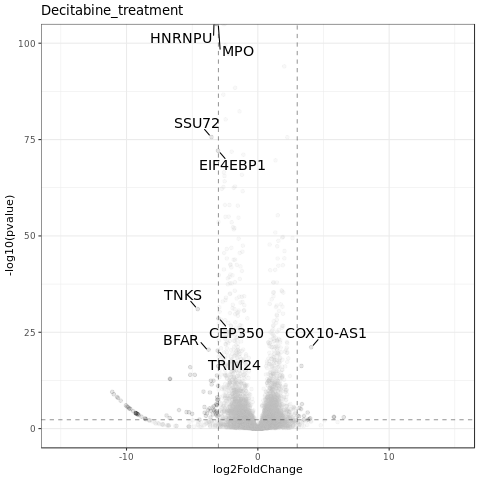

In [217]:
%%R
# significant thr 
pvalue_lim = 0.005; log2FoldChange_lim = 3
res$sig <- as.factor(
    res$pvalue < pvalue_lim &
    (res$log2FoldChange > log2FoldChange_lim & res$pvalue < pvalue_lim) |
    (res$log2FoldChange < (-1)*log2FoldChange_lim & res$pvalue < pvalue_lim)
)

relevel(res$sig, ref=TRUE)
# Volcano plot

v = res %>% ggplot(aes(x=log2FoldChange, y=-log10(pvalue),colour=sig, fill=sig)) +
        geom_point(aes(color = sig),alpha = 1/10) +
        ggtitle('Decitabine_treatment') +
        xlim(c(-15,15)) +
        ylim(c(0,100)) +
        geom_hline(yintercept=-log10(pvalue_lim), linetype="dashed", alpha = 4/10) +
        geom_vline(xintercept=log2FoldChange_lim, linetype="dashed", alpha = 4/10) +
        geom_vline(xintercept=(-1)*log2FoldChange_lim, linetype="dashed", alpha = 4/10) +
        scale_color_manual(values = c("grey", "black")) +
        theme_bw() + theme(legend.position="none") +
        geom_text_repel(
            data = subset(res[order(res$pvalue),], sig == TRUE)[1:10,],
            aes(label = name),
            size = 5,
            box.padding = unit(0.35, "lines"),
            point.padding = unit(0.3, "lines")
        )
ggsave("plots/peak_Volcanos.png", plot = v, device = 'png', dpi = 300)
ggsave("plots/peak_Volcanos.pdf", plot = v, device = 'pdf', dpi = 300)
v


In [218]:
res = %Rget res
res.sort_values('pvalue')


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,name,sig
ENSG00000196230.12_peak,32934.670168,-2.633326,0.067697,-38.898739,0.000000e+00,0.000000e+00,TUBB,FALSE
ENSG00000153187.18_peak,18565.943231,-3.177571,0.072183,-44.021117,0.000000e+00,0.000000e+00,HNRNPU,TRUE
ENSG00000185624.14_peak,53230.012498,-2.516796,0.060242,-41.778367,0.000000e+00,0.000000e+00,P4HB,FALSE
ENSG00000005381.7_peak,72644.854943,-3.132771,0.059094,-53.013172,0.000000e+00,0.000000e+00,MPO,TRUE
ENSG00000262831.1_peak,25918.529538,-2.425949,0.068558,-35.385574,2.846204e-274,5.325817e-271,RP11-498C9.2,FALSE
...,...,...,...,...,...,...,...,...
ENSG00000145990.10_peak,0.000000,NaN,NaN,NaN,NaN,NaN,GFOD1,NaN
ENSG00000149115.13_peak_3,0.000000,NaN,NaN,NaN,NaN,NaN,TNKS1BP1,NaN
ENSG00000162946.22_peak_2,0.000000,NaN,NaN,NaN,NaN,NaN,DISC1,NaN
ENSG00000179583.19_peak,0.000000,NaN,NaN,NaN,NaN,NaN,CIITA,NaN


### iPAGE

In [142]:
mk_dir('ipage')

In [172]:
%%bash 
awk 'NR>1{arr[$1]   += $3; count[$1] += 1}END{for (a in arr) {print substr(a,1,15)"\t"arr[a]/count[a]}}' deseq/peak_m6A_vs_input.txt > deseq/peak_m6A_vs_input.ave.txt
for f in `ls -d /flash/hani/bin/iPAGEv1.0/PAGE_DATA/ANNOTATIONS/human_ensembl*`; do
    base=`basename "$f"`
    perl $PAGEDIR/page.pl --expfile=deseq/peak_m6A_vs_input.ave.txt \
    --species=$base --exptype=continuous --ebins=11 --nodups=1
    mv -v deseq/peak_m6A_vs_input.ave.txt_PAGE/ ipage/peak_m6A_vs_input_${base}/
    cp -v ipage/peak_m6A_vs_input_${base}/peak_m6A_vs_input.ave.txt.summary.pdf plots/ipage.peak_m6A_vs_input_${base}.pdf
done

In [181]:
%%bash 
for i in `ls -d plots/ipage*png`; do
    o=${i/pdf/png};
    n=${i/plots\/ipage.peak_m6A_vs_input_human_ensembl_/};
    n=${n/.png/};
#     magick -density 300 $i -flatten -quality 90 $o
    echo '    <td><img src="'$o'" style="weight:100px">'
    echo $n
done

    <td><img src="plots/ipage.peak_m6A_vs_input_human_ensembl_encode_tf.png" style="weight:100px">
encode_tf
    <td><img src="plots/ipage.peak_m6A_vs_input_human_ensembl_msigdb_c1.png" style="weight:100px">
msigdb_c1
    <td><img src="plots/ipage.peak_m6A_vs_input_human_ensembl_msigdb_c2.png" style="weight:100px">
msigdb_c2
    <td><img src="plots/ipage.peak_m6A_vs_input_human_ensembl_msigdb_c3.png" style="weight:100px">
msigdb_c3
    <td><img src="plots/ipage.peak_m6A_vs_input_human_ensembl_msigdb_c4.png" style="weight:100px">
msigdb_c4
    <td><img src="plots/ipage.peak_m6A_vs_input_human_ensembl_msigdb_c5.png" style="weight:100px">
msigdb_c5
    <td><img src="plots/ipage.peak_m6A_vs_input_human_ensembl_msigdb_c6.png" style="weight:100px">
msigdb_c6
    <td><img src="plots/ipage.peak_m6A_vs_input_human_ensembl_msigdb_c7.png" style="weight:100px">
msigdb_c7
    <td><img src="plots/ipage.peak_m6A_vs_input_human_ensembl_msigdb_full.png" style="weight:100px">
msigdb_full
    <td><img sr

<table>
  <tr>
    <td><img src="plots/ipage.peak_m6A_vs_input_human_ensembl_msigdb_c1.png" style="weight:100px">
msigdb_c1
    <td><img src="plots/ipage.peak_m6A_vs_input_human_ensembl_msigdb_c2.png" style="weight:100px">
msigdb_c2
  <tr>
<table>
<table>
  <tr>
    <td><img src="plots/ipage.peak_m6A_vs_input_human_ensembl_msigdb_c4.png" style="weight:100px">
msigdb_c4
    <td><img src="plots/ipage.peak_m6A_vs_input_human_ensembl_msigdb_c5.png" style="weight:100px">
msigdb_c5
    <td><img src="plots/ipage.peak_m6A_vs_input_human_ensembl_msigdb_c6.png" style="weight:100px">
msigdb_c6
  <tr>
<table>
<table>
  <tr>
    <td><img src="plots/ipage.peak_m6A_vs_input_human_ensembl_msigdb_c7.png" style="weight:100px">
msigdb_c7
    <td><img src="plots/ipage.peak_m6A_vs_input_human_ensembl_msigdb_full.png" style="weight:100px">
msigdb_full
    <td><img src="plots/ipage.peak_m6A_vs_input_human_ensembl_msigdb_h.png" style="weight:100px">
msigdb_h
  <tr>
<table>
<table>
  <tr>
    <td><img src="plots/ipage.peak_m6A_vs_input_human_ensembl_encode_tf.png" style="weight:100px">
encode_tf
    <td><img src="plots/ipage.peak_m6A_vs_input_human_ensembl.png" style="weight:100px">
human_ensembl
    <td><img src="plots/ipage.peak_m6A_vs_input_human_ensembl_RBPs_all_gene_ids.png" style="weight:100px">
RBPs_all_gene_ids
  <tr>
<table>
<table>
  <tr>
    <td><img src="plots/ipage.peak_m6A_vs_input_human_ensembl_RBPs_coding_gene_ids_by_3UTR.png" style="weight:100px">
RBPs_coding_gene_ids_by_3UTR
    <td><img src="plots/ipage.peak_m6A_vs_input_human_ensembl_RBPs_coding_gene_ids_by_5UTR.png" style="weight:100px">
RBPs_coding_gene_ids_by_5UTR
    <td><img src="plots/ipage.peak_m6A_vs_input_human_ensembl_RBPs_coding_gene_ids_by_coding_exons.png" style="weight:100px">
RBPs_coding_gene_ids_by_coding_exons
  <tr>
<table>

### TEISER
https://github.com/goodarzilab/TEISER

In [ ]:
# %%bash
# declare -a StringArray=('METTL14' 'METTL3' 'Virma' 'WTAP')
# for treat in "${StringArray[@]}"; do
#     # ave duplicate: peaks  
# #     awk 'NR>1{arr[$1]   += $3; count[$1] += 1}END{for (a in arr) {print substr(a,1,15)"\t"arr[a]/count[a]}}' deseq/${treat}_peak_m6A_vs_input.txt > deseq/${treat}_peak_m6A_vs_input.ave.txt
#     # ave duplicate: exons 
# #     awk 'NR>1{arr[$1]   += $2; count[$1] += 1}END{for (a in arr) {print a"\t"arr[a]/count[a]}}' deseq/${treat}_peak_m6A_vs_input.ave.txt > deseq/${treat}_peak_m6A_vs_input.ave.c.txt
#     perl $TEISERDIR/run_mi_gene_list.pl \
#     --expfile=deseq/${treat}_peak_m6A_vs_input.ave.c.txt \
# #     --genefile=miRDB_miR-296-5p.predicted_targets_ens.list \
#     --exptype=continuous \
#     --ebins=7 \
#     --species=human \
#     --doremovedups=0 \
#     --doremoveextra=0
# done


In [ ]:
%%R
sessionInfo()